In [ ]:
!pip install japanize_matplotlib

In [1]:
from matplotlib import pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import pymc as pm
import arviz as az

# データの背景
IHDPデータセットは、低出生体重児を対象とした乳児健康・発達プログラムの介入効果を評価するために設計された実験研究（ランダム化比較試験：RCT）をもとにしています。
- 研究目的：早期介入が認知的・行動的発達に与える影響を評価する。
- 介入内容：医療支援・育児支援・教育的介入などの包括的なプログラム。
- 対象：出生体重が低い乳児およびその母親。
# データの構成
このデータセットは、もともとランダム化実験に基づいていますが、解析用には一部の介入群データが削除されており、観察研究のようなバイアスが人工的に導入されています。これにより、因果推論アルゴリズムの性能を現実的な条件下で検証することが可能になっています。
# 主な変数
- x: 各乳児に関する観測変数（母親の年齢、教育レベル、家庭環境など）
- t: 処置（1: 介入あり、0: 介入なし）
- y_factual: 実際に観測されたアウトカム
- y_cfactual: 反実仮想のアウトカム（本来観測できないが、ベンチマーク用にシミュレートされている）

In [2]:
# データの読み込み
df = pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_10.csv', header = None)
df.columns = ['T', 'y_factual', 'y_cfactual', 'mu0', 'mu1'] + [f'X_{i}' for i in range(1, 26)]
df.head()

,T,y_factual,y_cfactual,mu0,mu1,X_1,X_2,X_3,X_4,X_5,...,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25
0,1,24.534220,19.525653,21.221590,24.830999,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,22.981254,26.063482,21.354089,24.837223,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,16.006497,23.937630,18.040368,24.668592,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,24.243270,23.527574,25.759277,25.024775,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,38.693296,25.436166,38.671451,25.431081,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [3]:
# 潜在反応変数から観測変数を作成し、本来は観測できない変数を削除
df['Y'] = df['y_factual']
df.drop(['y_factual', 'y_cfactual', 'mu0', 'mu1'], axis=1, inplace=True)
df.head()

,T,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,Y
0,1,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,0,1,...,1,1,1,0,0,0,0,0,0,24.534220
1,0,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,0,0,...,1,1,1,0,0,0,0,0,0,22.981254
2,0,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,0,0,...,0,1,1,0,0,0,0,0,0,16.006497
3,0,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,0,0,...,0,1,1,0,0,0,0,0,0,24.243270
4,0,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,0,0,...,1,1,1,0,0,0,0,0,0,38.693296


In [4]:
# T=1のユニットのYの平均値とT=0のユニットのYの平均値の差を計算

Y_1_mean = df[df['T'] == 1]['Y'].mean()
Y_0_mean = df[df['T'] == 0]['Y'].mean()
diff = Y_1_mean - Y_0_mean

print(f'T=1のユニットのYの平均値: {Y_1_mean}')
print(f'T=0のユニットのYの平均値: {Y_0_mean}')
print(f'T=1のユニットのYの平均値とT=0のユニットのYの平均値の差: {diff}')

T=1のユニットのYの平均値: 24.81971344932516
T=0のユニットのYの平均値: 19.922672920785097
T=1のユニットのYの平均値とT=0のユニットのYの平均値の差: 4.897040528540064


In [5]:
# 傾向スコアの推定

X = df.drop(['T', 'Y'], axis=1).values
T = df['T'].values

# ロジスティック回帰モデルを用いて傾向スコアを推定
model = LogisticRegression(penalty=None)
model.fit(X, T)
ps = model.predict_proba(X)[:, 1]

# 推定された傾向スコアをデータフレームに追加
df['ps'] = ps

df.tail()

,T,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,Y,ps
742,0,-0.007654,-0.202946,-0.360898,0.161703,-0.316603,1.792063,0,0,1,...,1,0,0,0,0,0,0,0,23.593435,0.272310
743,1,0.727295,-0.202946,-0.733261,-0.879606,0.808706,1.129600,0,0,1,...,1,0,0,0,0,0,0,0,25.709389,0.381059
744,0,1.181234,0.196818,-1.477987,0.161703,0.746189,0.467138,0,0,0,...,1,0,0,0,0,0,0,0,16.604718,0.199730
745,0,-0.288664,-0.202946,-1.477987,-0.879606,1.621430,0.467138,1,0,1,...,1,0,0,0,0,0,0,0,28.624417,0.300170
746,0,-0.137351,0.596582,-0.360898,-0.879606,0.496120,0.135907,0,0,1,...,1,0,0,0,0,0,0,0,28.547316,0.332490


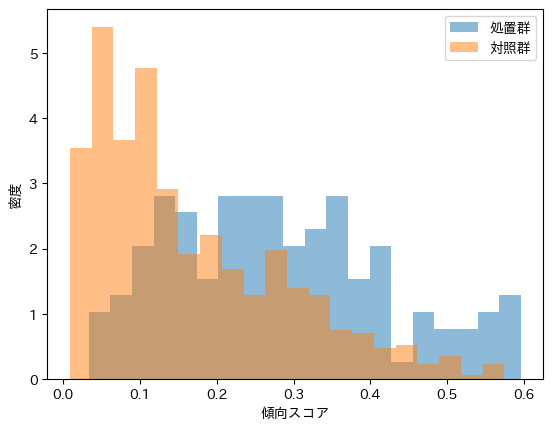

In [6]:
# 処置群と統制群で傾向スコアの分布を比較

plt.hist(df[df['T'] == 1]['ps'], bins=20, alpha=0.5, density=True, label='処置群')
plt.hist(df[df['T'] == 0]['ps'], bins=20, alpha=0.5, density=True, label='対照群')
plt.xlabel('傾向スコア')
plt.ylabel('密度')
plt.legend()
plt.show();

In [7]:
# マッチング推定により平均処置効果を推定

# 処置群と統制群の傾向スコアが近いユニット同士をマッチング
df_1 = df[df['T'] == 1].copy()
df_0 = df[df['T'] == 0].copy()

matched_rows = []

for i, row in df_1.iterrows():
    dist = np.abs(df_0['ps'] - row['ps'])
    min_idx = dist.idxmin()
    
    # 処置群と統制群を1行にまとめる
    matched_pair = {
        'T1_index': i,                     # 処置群のインデックス
        'T1_ps': row['ps'],                # 処置群の傾向スコア
        'T1_outcome': row['Y'],      # 処置群のアウトカム
        'T0_index': min_idx,               # 統制群のインデックス
        'T0_ps': df_0.loc[min_idx, 'ps'],  # 統制群の傾向スコア
        'T0_outcome': df_0.loc[min_idx, 'Y']  # 統制群のアウトカム
    }
    matched_rows.append(matched_pair)

# データフレームに変換
df_match = pd.DataFrame(matched_rows)

df_match.tail()

,T1_index,T1_ps,T1_outcome,T0_index,T0_ps,T0_outcome
134,706,0.261050,24.302608,293,0.262479,26.385483
135,714,0.216681,24.987891,257,0.216516,32.526760
136,715,0.418373,24.249801,561,0.416963,23.064568
137,717,0.446089,25.847667,634,0.448104,11.914743
138,743,0.381059,25.709389,596,0.381227,17.224030


In [8]:
df_match['T1_outcome'] - df_match['T0_outcome']

0       6.270494
1       4.505379
2       0.893365
3       7.413539
4       7.325907
         ...    
134    -2.082874
135    -7.538868
136     1.185233
137    13.932924
138     8.485359
Length: 139, dtype: float64

In [9]:
df_match['T1_outcome'].mean() - df_match['T0_outcome'].mean()

4.071474571026059

In [10]:
# 重回帰分析により平均処置効果を推定

# 重回帰分析
Y = df['Y'].values
T_X = df.drop(['Y'], axis=1)

model = sm.OLS(Y, sm.add_constant(T_X))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     89.03
Date:                Sat, 22 Nov 2025   Prob (F-statistic):          1.27e-208
Time:                        17:04:59   Log-Likelihood:                -2124.6
No. Observations:                 747   AIC:                             4305.
Df Residuals:                     719   BIC:                             4434.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7927      2.042      3.327      0.001       2.784      10.801
T              3.9699      0.424      9.373      0.000       3.138       4.801
X_1           -0.5265      0.436     -1.209      0.227      -1.382       0.329
X_2            0.5239      0.319      1.640      0.101      -0.103       1.151
X_3           -0.3038      0.310     -0.980      0.327      -0.912       0.305
X_4           -0.4082      0.299     -1.364      0.173      -0.996       0.179
X_5            4.1262      0.190     21.753      0.000       3.754       4.499
X_6            0.0015      0.237      0.006      0.995      -0.464       0.467
X_7            0.4674      0.346      1.351      0.177      -0.212       1.147
X_8            2.9505      0.560      5.271      0.000       1.851       4.050
X_9            4.5569      0.437     10.426      0.000       3.699       5.415
X_10           0.3193      0.644      0.496      0.620      -0.945       1.583
X_11           0.0729      0.620      0.118      0.906      -1.144       1.290
X_12           3.7924      0.644      5.886      0.000       2.527       5.057
X_13           7.0539      0.386     18.251      0.000       6.295       7.813
X_14          -0.3595      0.588     -0.612      0.541      -1.514       0.795
X_15          -0.2116      0.498     -0.425      0.671      -1.189       0.766
X_16           3.9343      0.973      4.042      0.000       2.023       5.846
X_17           3.7478      0.371     10.115      0.000       3.020       4.475
X_18           1.7641      0.918      1.922      0.055      -0.038       3.566
X_19           4.0562      0.768      5.282      0.000       2.548       5.564
X_20          -1.8931      1.166     -1.623      0.105      -4.183       0.397
X_21           4.7630      0.853      5.583      0.000       3.088       6.438
X_22          -1.7376      1.093     -1.590      0.112      -3.883       0.408
X_23          -1.5492      1.316     -1.177      0.239      -4.132       1.034
X_24          -1.9665      1.075     -1.829      0.068      -4.077       0.144
X_25          -0.7273      0.603     -1.205      0.228      -1.912       0.457
ps            -3.4919      4.528     -0.771      0.441     -12.381       5.398
==============================================================================
Omnibus:                      186.814   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1169.130
Skew:                           0.967   Prob(JB):                    1.34e-254
Kurtosis:                       8.815   Cond. No.                         86.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, s_e]


Output()

Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]    6.455  1.947   3.028   10.281      0.022    0.014    7814.0   
beta[1]    3.963  0.422   3.175    4.740      0.003    0.003   26865.0   
beta[2]   -0.577  0.419  -1.378    0.194      0.004    0.003    8795.0   
beta[3]    0.519  0.324  -0.074    1.142      0.002    0.002   18579.0   
beta[4]   -0.332  0.302  -0.901    0.237      0.003    0.002    9855.0   
beta[5]   -0.375  0.295  -0.918    0.195      0.002    0.002   15013.0   
beta[6]    4.139  0.189   3.786    4.494      0.002    0.001   14404.0   
beta[7]   -0.016  0.233  -0.465    0.407      0.002    0.001   13452.0   
beta[8]    0.449  0.341  -0.199    1.086      0.003    0.002   13995.0   
beta[9]    2.949  0.558   1.932    4.009      0.004    0.004   25300.0   
beta[10]   4.512  0.426   3.733    5.329      0.004    0.003   12062.0   
beta[11]   0.334  0.633  -0.880    1.513      0.005    0.004   13454.0   
beta[12]   0.111  0.606  -1.048    1.2

<Figure size 700x400 with 0 Axes>

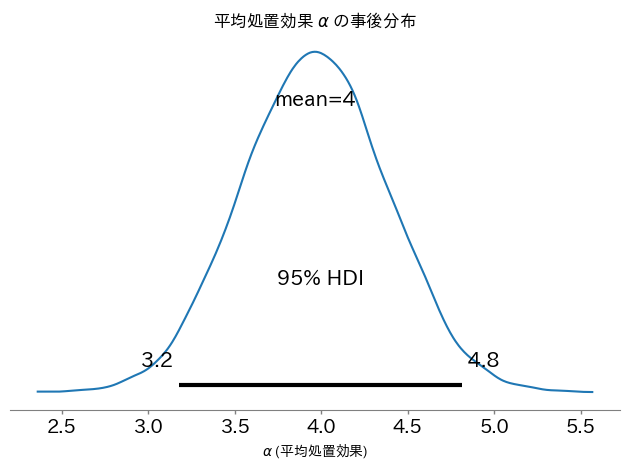

In [ ]:
# ======================
# 事前分布の設定
# ======================
prior_beta_mean = 0
prior_beta_s = 0.01      # β の precision（精度）→ 共分散は I / prior_beta_s
prior_s_e_a = 1          # s_e = 1/σ² の Gamma 事前 shape
prior_s_e_b = 50         # s_e の Gamma 事前 rate

# ======================
# データ準備
# ======================
np.random.seed(0)
X = sm.add_constant(df.drop(['Y'], axis=1))
y = Y.values if hasattr(Y, "values") else np.asarray(Y)
n, p = X.shape

# ======================
# PyMC モデル定義
#   y ~ Normal(Xβ, σ² I)
#   β ~ N(0, (prior_beta_s I)^(-1))
#   s_e = 1/σ² ~ Gamma(a, b)
# ======================
with pm.Model() as model:
    # β の事前：MvNormal(μ=0, Σ=I/prior_beta_s)
    beta = pm.MvNormal(
        "beta",
        mu=np.full(p, prior_beta_mean),
        cov=np.eye(p) / prior_beta_s
    )

    # 誤差精度 s_e の事前
    s_e = pm.Gamma("s_e", alpha=prior_s_e_a, beta=prior_s_e_b)

    # σ² と σ を派生量として定義
    sig2_e = pm.Deterministic("sig2_e", 1.0 / s_e)
    sigma = pm.Deterministic("sigma", pm.math.sqrt(sig2_e))

    # 線形予測子
    mu = pm.math.dot(X, beta)

    # 観測モデル
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # MCMC サンプリング
    idata = pm.sample(
        draws=10000,      # 事後サンプル数（元の n_iter に対応）
        tune=2000,
        chains=2,
        random_seed=0,
        return_inferencedata=True,
    )

# 全係数と分散の要約
print(az.summary(idata, var_names=["beta", "sig2_e", "sigma", "s_e"]))

# ======================
# β₁（平均処置効果）の事後サンプルを取り出す
# ======================
# beta: (chain, draw, p) → (n_samples, p)
beta_samples = (
    idata.posterior["beta"]
    .stack(sample=("chain", "draw"))
    .values.T     # shape: (n_samples, p)
)
alpha_samples = beta_samples[:, 1]   # 処置効果に対応する係数

# 95%信用区間
lower = np.percentile(alpha_samples, 2.5)
upper = np.percentile(alpha_samples, 97.5)

print(f'重回帰分析のベイズ推定による平均処置効果: {alpha_samples.mean()}')
print(f'95%信用区間: ({lower}, {upper})')

# ======================
# 事後分布のプロット（az.plot_posterior を使用）
# ======================
plt.figure(figsize=(7, 4))
az.plot_posterior(alpha_samples, point_estimate="mean", hdi_prob=0.95)
plt.xlabel(r'$\alpha$ (平均処置効果)')
plt.title(r'平均処置効果 $\alpha$ の事後分布')
plt.tight_layout()
plt.show()
